# INTRODUCTION

Mets Questionnaire Problem: 

For this question we are asked to develop a model that predicts the probability that a pitch is one of the below pitch types:

a. 4-Seam Fastball<br>
b. 2-Seam Fastball<br>
c. Curveball<br>
d. Slider<br>
e. Changeup


# Column Descriptions for Pitch Data

inning – The inning in which the pitch occurred<br>
is_bottom – Indicator for either the top of bottom of the inning (1=bottom)<br>
balls – number of balls in the count before the pitch<br>
strikes – number of strikes in the count before the pitch<br>
outs_before – number of outs before the pitch<br>
is_lhp – indicates whether the pitcher is left-handed (1=yes)<br>
is_lhb – indicates whether the batter is batting from the left side (1=yes)<br>
pitch_type – indicates which pitch was thrown:<br>
FF = 4-Seam Fastball<br>
FT = 2-Seam Fastball <br>
CB = Curveball<br>
SL = Slider<br>
CH = Changeup<br>
bat_score_before – number of runs scored by the batting team before the pitch<br>
field_score – number of runs scored by the fielding team before the pitch <br>
basecode_before – base state before the pitch:<br>
0 = no runners on base<br>
1= runner on first base<br>
2 = runner on second base<br>
3 = runners on first and second base<br>
4 = runner on third base<br>
5 = runners on first and third base<br>
6 = runners on second and third base<br>
7 = runners on first, second, and third base<br>
batterid – unique identifier for the batter<br>
pitcherid – unique identifier for the pitcher <br>
cid – unique identifier for the catcher<br>

In [78]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random as rm
import pickle
import os
from collections import Counter

from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

# EXPLORING THE DATA

Import the given Pitching data and store it as a DataFrame

In [28]:
pitch_train = pd.read_csv('data/Q2_pitches_train.csv')
pitch_test = pd.read_csv('data/Q2_pitches_test.csv')

In [29]:
#Take a look at the data that we will be using to train our model
pitch_train.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,FF,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,FT,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,FF,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,SL,6,1,1,460,1100,2050


In [30]:
#Take a look at the data that we will be using to test our prediction model
pitch_test

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,NaN,NaN,NaN,NaN,NaN
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,NaN,NaN,NaN,NaN,NaN
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,NaN,NaN,NaN,NaN,NaN
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160301,1,0,0,1,0,0,1,0,0,1,367,1506,2060,NaN,NaN,NaN,NaN,NaN
160302,1,0,0,1,0,0,0,0,0,3,157,1506,2060,NaN,NaN,NaN,NaN,NaN
160303,1,0,3,2,0,0,1,0,0,0,159,1506,2060,NaN,NaN,NaN,NaN,NaN
160304,1,0,3,2,0,0,1,0,0,0,159,1506,2060,NaN,NaN,NaN,NaN,NaN


In [31]:
#Looking to see the what kind of datatypes we are working with
pitch_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480915 entries, 0 to 480914
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   inning            480915 non-null  int64 
 1   is_bottom         480915 non-null  int64 
 2   balls             480915 non-null  int64 
 3   strikes           480915 non-null  int64 
 4   outs_before       480915 non-null  int64 
 5   is_lhp            480915 non-null  int64 
 6   is_lhb            480915 non-null  int64 
 7   pitch_type        480915 non-null  object
 8   bat_score_before  480915 non-null  int64 
 9   field_score       480915 non-null  int64 
 10  basecode_before   480915 non-null  int64 
 11  batterid          480915 non-null  int64 
 12  pitcherid         480915 non-null  int64 
 13  cid               480915 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 51.4+ MB


<AxesSubplot:>

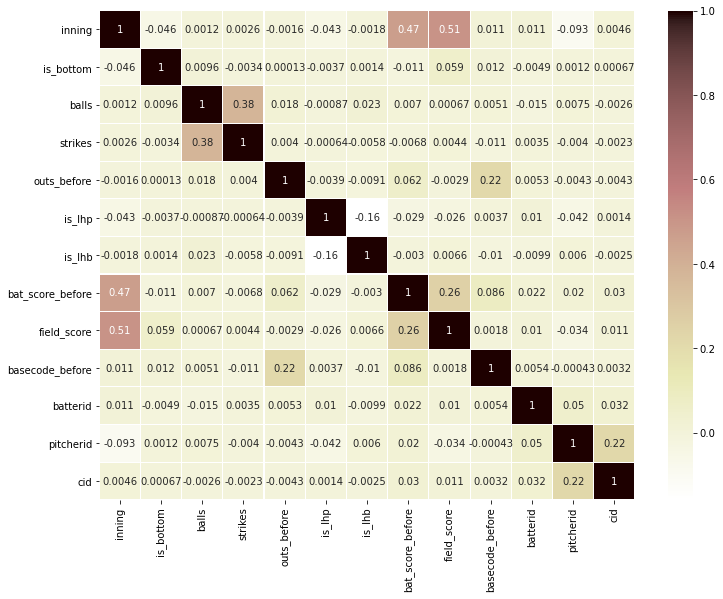

In [32]:
plt.figure(figsize=(12, 9))

# Create a heatmap with all the features and with individual annotation to check for multicollinearity between
# the features.
correlation = pitch_train.corr()  
sns.heatmap(correlation, annot=True,linewidth=.1, cmap='pink_r')

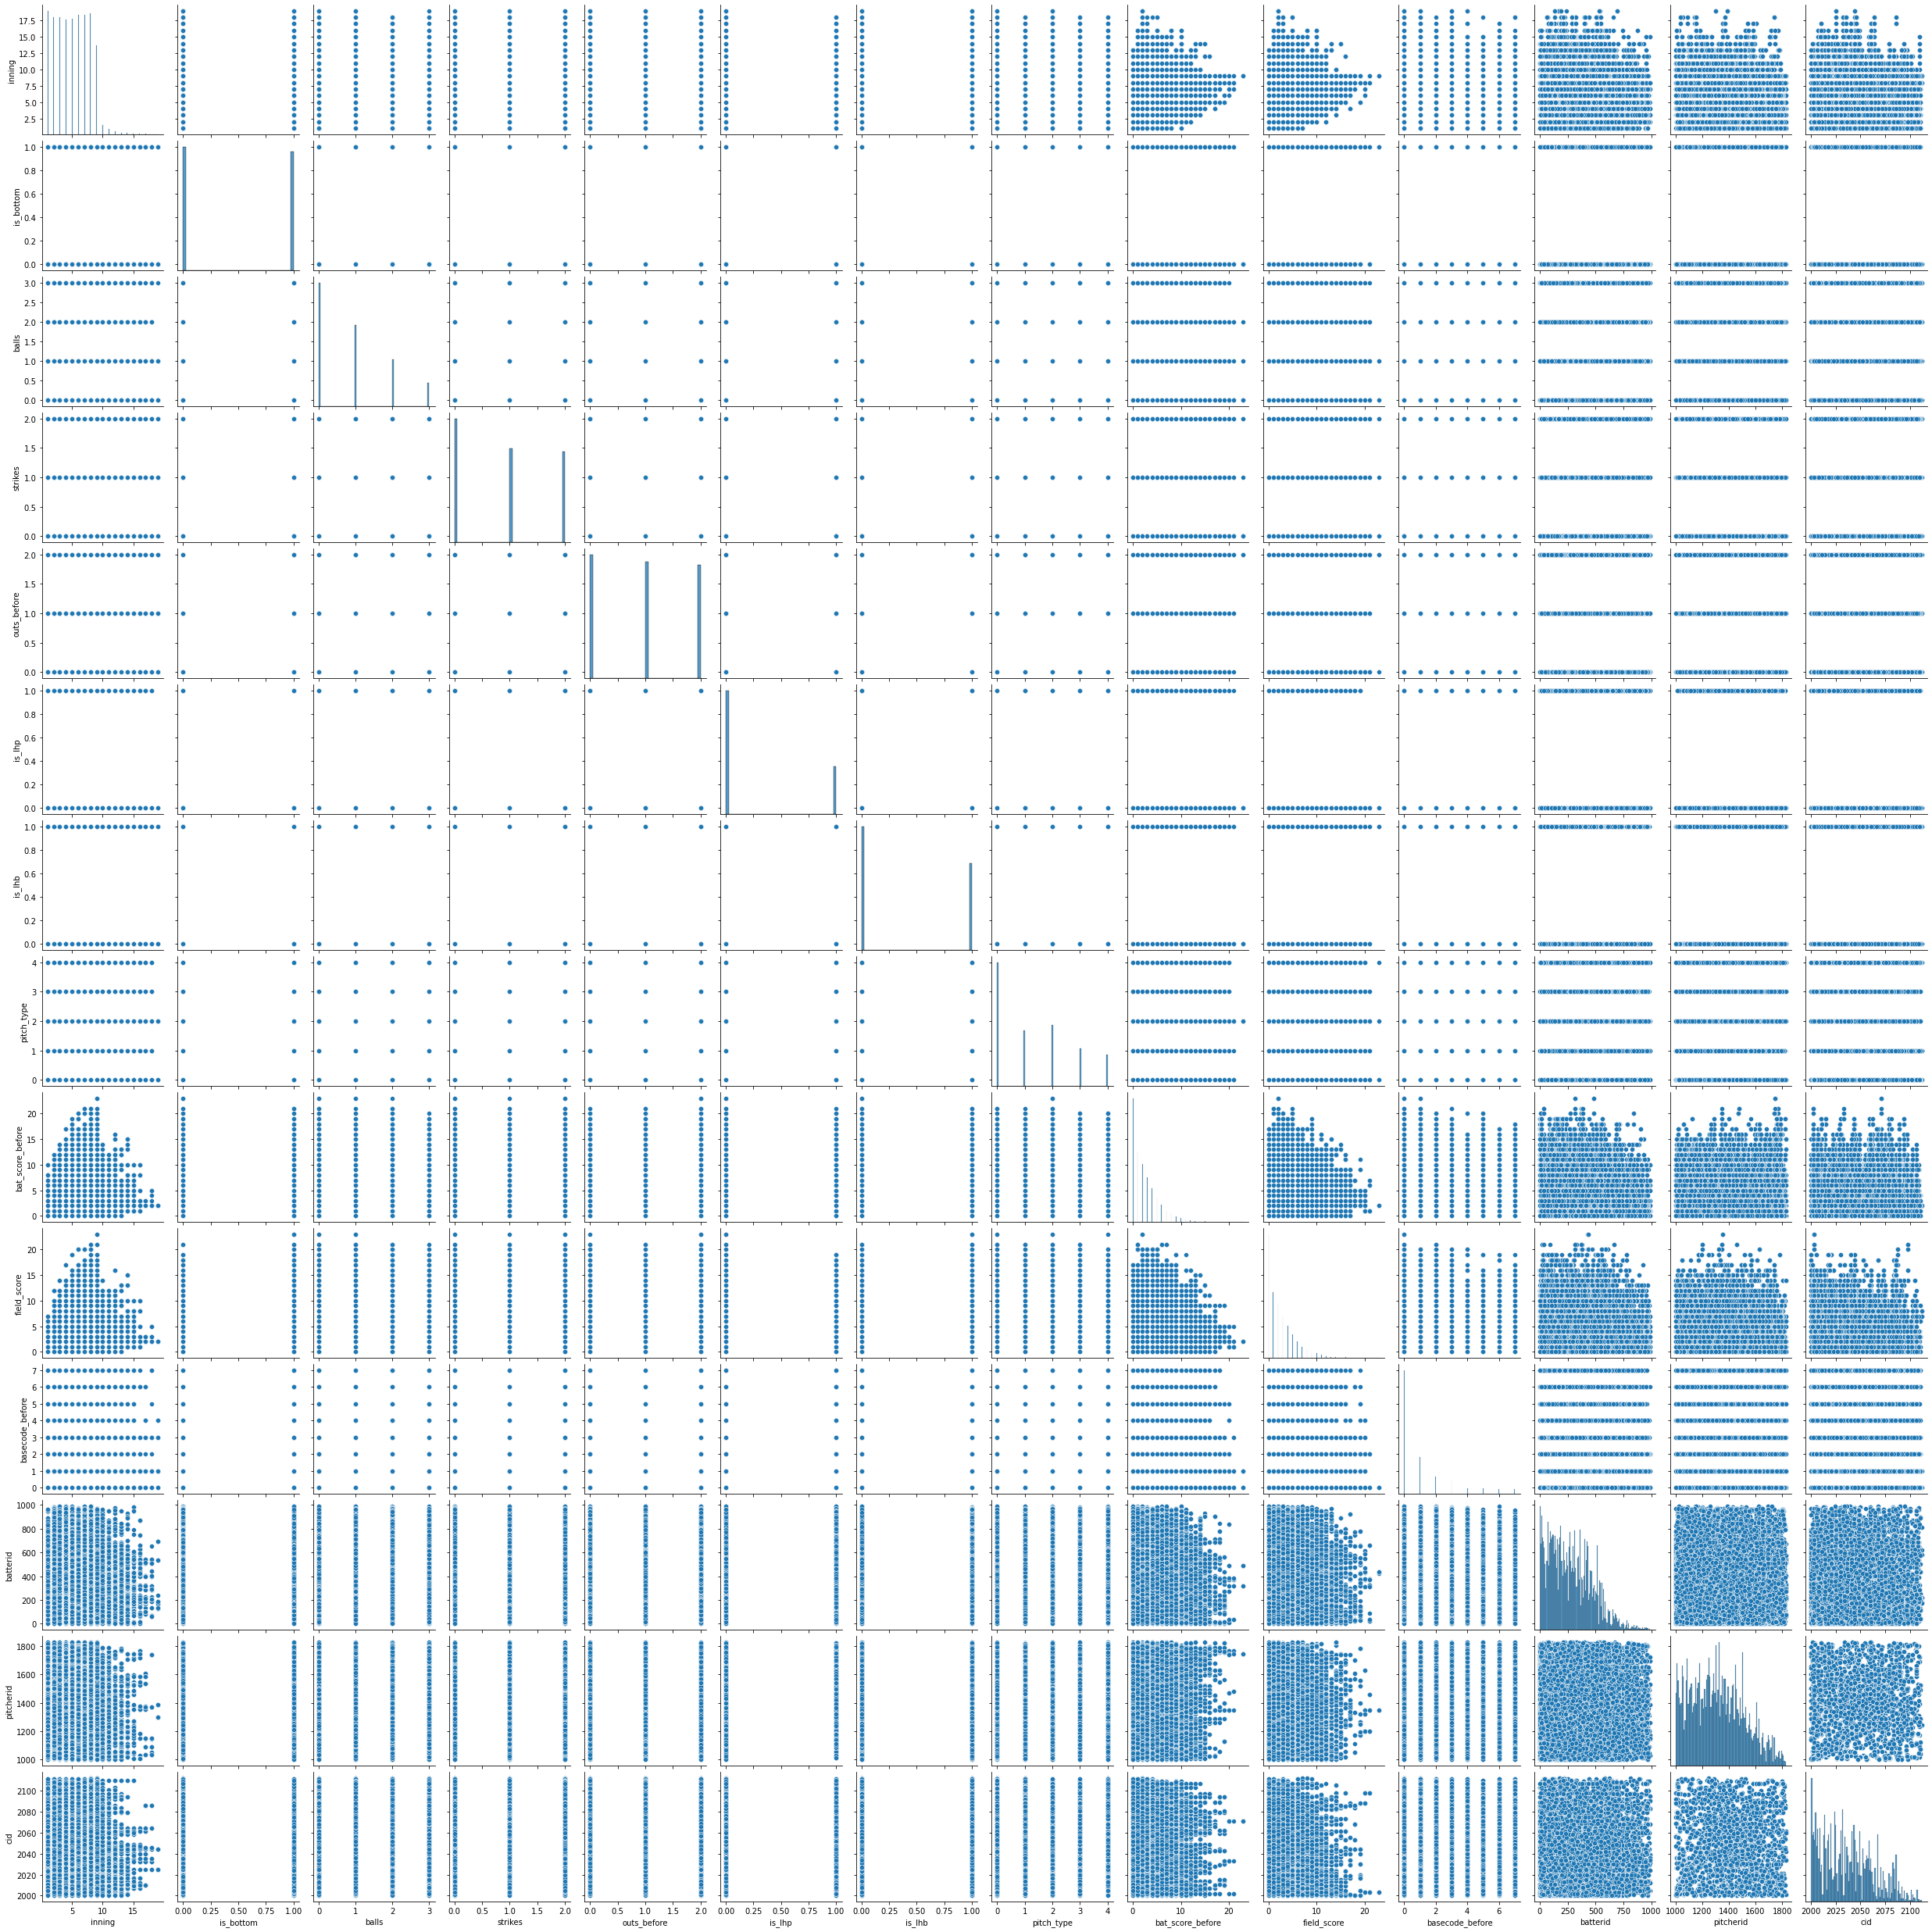

In [19]:
#pairplot visual to look at linear relationships, data distributions and types of data
sns.pairplot(data = pitch_train)

Based on the graphs above and for model training purposes, I will not be dropping any columns. 

Before we make a prediction model, lets look into the total pitches for each pitch type.
This can allow us to see and make a blind assumption as to which type of pitch will have a higher probability of being thrown.

In [33]:
pitch = pitch_train.pitch_type.value_counts()
pitch

FF    192805
SL     95580
FT     86222
CH     58220
CB     48088
Name: pitch_type, dtype: int64

<AxesSubplot:>

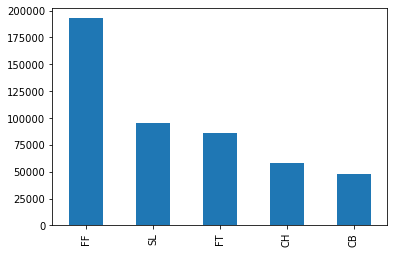

In [34]:
#Visualize series above
pitch.plot(kind = 'bar')

From the bar plot above, I can make a blind assumption that if these pitch types are in a pitchers arsenal,
the four seam fastball wil have the highest probability of being thrown and the curveball will have the lowest.

# CLEANING DATAFRAME FOR TRAINING

In [54]:
#Drop the pitch_type column and store the other cloumns in a seperate df. This will be our features.
features = pitch_train.drop(['pitch_type'], axis = 1)
features

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,6,1,1,460,1100,2050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480910,4,1,1,1,2,0,1,2,0,0,545,1214,2052
480911,4,1,3,2,0,0,0,1,3,0,218,1430,2086
480912,6,0,2,1,1,0,0,1,2,1,134,1212,2052
480913,1,0,1,2,2,1,0,0,0,0,39,1541,2044


In [48]:
#Since we are predicting probability of the pitch type that will thrown, this will be our target.
target = pitch_train['pitch_type']
target

0         0
1         0
2         1
3         0
4         2
         ..
480910    3
480911    4
480912    2
480913    3
480914    0
Name: pitch_type, Length: 480915, dtype: int64

To make the data frame more uniformed and to use for training and testing the model, I will be changing the Pitch_type datatype to numerial values. 

In [38]:
# Quantifies the categories in the target variable
pitch_train['pitch_type'] = pitch_train['pitch_type'].replace({'FF': 0, 'FT': 1, 'SL': 2, 'CH': 3, 'CB': 4})

In [56]:
#Split the the data set into two sets: a training set and a testing set. 80% for training, and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

To predict the probabilities of each pitch type beinf thrown, I will be using GaussianNB machine learning algorithm as it implements the Gaussian Naive Bayes algorithm for classification. 

In [57]:
bayes = GaussianNB()

#Perform classification on an array of test vectors
pred_bayes = bayes.fit(X_train, y_train).predict(X_test)

#gets probabilities for pitches
pred = bayes.predict_proba(X_test)
pred

array([[0.41754205, 0.16346281, 0.17056383, 0.13073341, 0.11769791],
       [0.34367868, 0.14860321, 0.16300005, 0.24189844, 0.10281962],
       [0.39243662, 0.19031471, 0.17831905, 0.1099676 , 0.12896202],
       ...,
       [0.5012159 , 0.15454584, 0.29529644, 0.0215603 , 0.02738153],
       [0.37321927, 0.10632747, 0.41439602, 0.05661316, 0.04944408],
       [0.34051175, 0.15649132, 0.33428871, 0.08899822, 0.07971   ]])

In [58]:
bayes.class_prior_

array([0.40079848, 0.17878159, 0.19891509, 0.12122984, 0.100275  ])

# PREDICTING PROBABILITIES OF PITCH THROWN

In [70]:
#Gives us the probabilities for each pitch type
test_pred = bayes.predict_proba(features)
test_pred

array([[0.41573262, 0.19226039, 0.11529638, 0.15188073, 0.12482988],
       [0.37150086, 0.14449832, 0.12414683, 0.24318207, 0.11667193],
       [0.39528218, 0.23792461, 0.14707841, 0.09365125, 0.12606354],
       ...,
       [0.4039982 , 0.19826899, 0.20890899, 0.12596508, 0.06285873],
       [0.32510899, 0.13348391, 0.14298217, 0.22882086, 0.16960407],
       [0.33578586, 0.24355837, 0.14726114, 0.14113507, 0.13225956]])

In [71]:
# fill_data = {}
test_pred[0]

array([0.41573262, 0.19226039, 0.11529638, 0.15188073, 0.12482988])

Now that we have our predictions, it is time to fill out the pitch_test dataframe with our predictions.

In [72]:
FF = []
FT = []
CB = []
SL = []
CH = []
# Creates a new dataframe with filled in values to join to the test dataframe.
for data in test_pred:
    FF.append(data[0])
    FT.append(data[1])
    CB.append(data[2])
    SL.append(data[3])
    CH.append(data[4])
filled_data = {'FF': FF, 'FT': FT, 'CB': CB, 'SL': SL, 'CH': CH}
df = pd.DataFrame(filled_data)

In [73]:
test_prediction = features.join(df)

In [74]:
test_prediction.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,3,0,1,0,1,0,1,0,1,0,347,1304,2014,0.415733,0.192260,0.115296,0.151881,0.124830
1,1,0,2,2,2,1,0,0,0,0,269,1661,2052,0.371501,0.144498,0.124147,0.243182,0.116672
2,2,1,0,0,0,0,0,0,0,0,43,1048,2029,0.395282,0.237925,0.147078,0.093651,0.126064
3,7,0,0,0,1,0,0,5,1,1,98,1521,2049,0.380428,0.190500,0.234115,0.076930,0.118026
4,7,1,0,0,2,1,1,6,1,1,460,1100,2050,0.362730,0.206949,0.145921,0.148962,0.135438


In [68]:
#To make sure all of the the pitch types have been filled.
test_prediction.shape

(160306, 18)

In [75]:
#Check for null values 
test_prediction.isnull().values.any()

False

In [76]:
#save dataframe as csv file
test_prediction.to_csv('Q2_pitch_answers.csv') 